In [0]:
tpu = False

In [0]:
# mount drive and run all
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# check connnection
!ls "/content/drive/My Drive/app_UNOSAT/src"

funcs_deep_learning.py	main.py			__pycache__	 utils.py
__init__.py		prepare_for_network.py	rasterize.py
load_data.py		preprocessing.py	run_pipeline.py


In [0]:
if not tpu:
  !pip install keras_unet 
  !pip install geopandas 
  !pip install rasterio
  !pip install pyproj


from IPython.display import display, HTML
js = ('<script>function ConnectButton(){ '
        'console.log("Connect pushed"); '
        'document.querySelector("#connect").click()} '
        'setInterval(ConnectButton,3000);</script>')
display(HTML(js))

     |████████████████████████████████| 18.0MB 200kB/s 


In [0]:
from datetime import datetime
import os
from os.path import join
from pprint import pprint
import sys
import time
import warnings
import yaml

import h5py
import tensorflow as tf

if tpu:
  from tensorflow.keras import backend as K
  from tensorflow.keras.models import load_model
  from tensorflow.keras import callbacks as keras_cb 
  from tensorflow.keras.optimizers import Adam
  from tensorflow.keras.utils import Sequence
else:
  from keras import backend as K
  from keras.models import load_model
  from keras import callbacks as keras_cb 
  from keras.optimizers import Adam
  from keras.utils import Sequence

import matplotlib.pyplot as plt
import numpy as np

#tf.logging.set_verbosity(tf.logging.ERROR)

# # see: https://github.com/karolzak/keras-unet
# if tpu:
#   from my_keras_unet.models import satellite_unet 
#   from my_keras_unet.losses import jaccard_distance
#   from my_keras_unet.metrics import iou, iou_thresholded
#   from my_keras_unet.utils import get_augmented
if not tpu:
  from keras_unet.models import satellite_unet 
  from keras_unet.losses import jaccard_distance
  from keras_unet.metrics import iou, iou_thresholded
  from keras_unet.utils import get_augmented

print(sys.executable)
sys.path.append("/content/drive/My Drive/app_UNOSAT")
sys.path.append("/content/drive/My Drive/app_UNOSAT/src")

from src import funcs_deep_learning as dl
from src import load_data as ld
from src import preprocessing as pp
from src import prepare_for_network as pfn
from src import utils as utl

/usr/bin/python3


In [0]:
if tpu:
  # check availability TPU

  if 'COLAB_TPU_ADDR' not in os.environ:
      print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
  else:
      tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
      print ('TPU address is', tpu_address)

      with tf.Session(tpu_address) as session:
        devices = session.list_devices()

      print('TPU devices:')
      pprint(devices)

TPU address is grpc://10.116.192.130:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 9569002694740800453),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 5503561391176546861),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 2666966215359372684),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 1170054001886047667),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 5343965121274931113),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 786032306924517846),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 15420790469191153036),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 2563435355401070285),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 35090528288973

In [0]:
if tpu:
  # setup TPU strategy
  resolver = tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.contrib.distribute.initialize_tpu_system(resolver)
  strategy = tf.contrib.distribute.TPUStrategy(resolver)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Initializing the TPU system: 10.116.192.130:8470
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Querying Tensorflow master (grpc://10.116.192.130:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 9569002694740800453)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 2666966215359372684)

In [0]:
# local paths, set your own path here
path_main = '/content/drive/My Drive/app_UNOSAT'
path_data_main = utl.make_dir(join(path_main, "data"))

#### put data in these dirs

# I choose:
# Training: Mosul, Najaf, Nasiryah
# Validation: Souleimaniye
# Test: Bagdad, Kirkouk, Samawah, Tikrit (no labels present)
path_data_local_train = join(path_data_main, 'Train_Dataset')
path_data_local_val = join(path_data_main, 'Validation_Dataset')
path_data_local_test = join(path_data_main, 'Evaluation_Dataset')

path_model = utl.make_dir(join(path_data_main, 
                               'model_{}'.format(utl.datetime_now())))
path_checkpoints =  utl.make_dir(join(path_model, 'checkpoints'))

In [0]:
# other dirs are made automatically
dir_temp_data =  utl.make_dir(join(path_data_main, 'data_temp'))
dir_temp_train = utl.make_dir(join(dir_temp_data, 'train'))
dir_temp_val = utl.make_dir(join(dir_temp_data, 'val'))
dir_temp_dev = utl.make_dir(join(dir_temp_data, 'data_dev'))
dir_temp_eval = utl.make_dir(join(dir_temp_data, 'evaluation'))
dir_temp_plots = utl.make_dir(join(dir_temp_data, 'plots_preprocessing'))

In [0]:
# settings preprocessing
quantile_clip_max = 0.999
dtype = np.uint16
inv_stride = 2

# Load and preprocess

In [0]:
t0 = time.time()
dict_paths_train = ld.paths_in_dict(path_data_local_train)

file_hfd5_train_X = join(dir_temp_train, 'MosNajNaS_20191223_X_{}.hdf5'.format(patch_size[0]))
file_hfd5_train_Y = join(dir_temp_train, 'MosNajNaS_20191223_Y_{}.hdf5'.format(patch_size[0]))

pp.preprocces_data(dict_paths_train, file_hfd5_train_X, quantile_clip_max, patch_size, dtype, dir_temp_plots,
                    apply_log=True, a_l=1, b_l=0.2)
pp.preprocess_shape(dict_paths_train, file_hfd5_train_Y, patch_size, dtype_labels)

print('takes {} mins'.format(round((time.time() - t0)/60)))

FileNotFoundError: ignored

In [0]:
t0 = time.time()
dict_paths_val = ld.paths_in_dict(path_data_local_val)

file_hfd5_val_X = join(dir_temp_val, 'Sou_20191223_X_{}.hdf5'.format(patch_size[0]))
file_hfd5_val_Y = join(dir_temp_val, 'Sou_20191223_Y_{}.hdf5'.format(patch_size[0]))

pp.preprocces_data(dict_paths_val, file_hfd5_val_X, quantile_clip_max, patch_size, dtype, dir_temp_plots,
                   apply_log=True, a_l=a_l, b_l=b_l)
pp.preprocess_shape(dict_paths_val, file_hfd5_val_Y, patch_size, dtype_labels)

print('takes {} mins'.format(round((time.time() - t0)/60)))

FileNotFoundError: ignored

# Prepare for network

In [0]:
file_hfd5_train_X = join(dir_temp_train, 'MosNajNaS_20191223_X_{}.hdf5'.format(patch_size[0]))
file_hfd5_train_X_patches = join(dir_temp_train,  'MosNajNaS_20191223_X_{}_patches.hdf5'.format(patch_size[0]))

depth_img = 8
stride_mode = [1,4][1] 
name_dset = 'all_train_data_X'
dataset_kind = 'data'

pfn.prepare_data_for_nn_pipeline(file_hfd5_train_X,
                                 file_hfd5_train_X_patches,
                                 patch_size,
                                 stride_mode, 
                                 name_dset,
                                 dtype,
                                 inv_stride,
                                 dataset_kind,
                                 depth_img)

file_hfd5_train_Y = join(dir_temp_train, 'MosNajNaS_20191223_Y_{}.hdf5'.format(patch_size[0]))
file_hfd5_train_Y_patches = join(dir_temp_train, 'MosNajNaS_20191223_Y_{}_patches.hdf5'.format(patch_size[0]))
stride_mode = [1,4][1]  # 1
name_dset = 'all_train_data_Y'
dataset_kind = 'labels'


pfn.prepare_data_for_nn_pipeline(file_hfd5_train_Y, 
                                 file_hfd5_train_Y_patches,
                                 patch_size,
                                 stride_mode, 
                                 name_dset,
                                 dtype,
                                 inv_stride,
                                 dataset_kind)

file_hfd5_val_X = join(dir_temp_val, 'Sou_20191223_X_{}.hdf5'.format(patch_size[0]))
file_hfd5_val_X_patches = join(dir_temp_val,  'Sou_20191223_X_{}_patches.hdf5'.format(patch_size[0]))

depth_img = 8
stride_mode = [1,4][1] 
name_dset = 'all_val_data_X'
dataset_kind = 'data'

pfn.prepare_data_for_nn_pipeline(file_hfd5_val_X,
                                 file_hfd5_val_X_patches,
                                 patch_size,
                                 stride_mode, 
                                 name_dset,
                                 dtype,
                                 inv_stride,
                                 dataset_kind,
                                 depth_img)

file_hfd5_val_Y = join(dir_temp_val, 'Sou_20191223_Y_{}.hdf5'.format(patch_size[0]))
file_hfd5_val_Y_patches = join(dir_temp_val, 'Sou_20191223_Y_{}_patches.hdf5'.format(patch_size[0]))
stride_mode = [1,4][1]  # 1
name_dset = 'all_val_data_Y'
dataset_kind = 'labels'


pfn.prepare_data_for_nn_pipeline(file_hfd5_val_Y, 
                                 file_hfd5_val_Y_patches,
                                 patch_size,
                                 stride_mode, 
                                 name_dset,
                                 dtype,
                                 inv_stride,
                                 dataset_kind)

# Deep learning

In [0]:
# params
BS = 4
EPOCHS = 200
patch_size = (512, 512)
num_layers = 2

In [0]:
inv_stride = 2
INIT_LR = 1e-3
depth_img = 8
stride_mode = 4

IMAGE_DIMS = patch_size + (depth_img,)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

if not tpu:
  model = satellite_unet(IMAGE_DIMS, num_layers=num_layers)
print(IMAGE_DIMS)














(512, 512, 8)


In [0]:
class My_Custom_Generator(Sequence):
    def __init__(self, file_hdf5_X, file_hdf5_Y, batch_size, name_dset_X, name_dset_Y,
                 dtype):
        self.file_hdf5_X = file_hdf5_X
        self.file_hdf5_Y = file_hdf5_Y
        self.batch_size = batch_size
        self.name_dset_X = name_dset_X
        self.name_dset_Y = name_dset_Y
        self.dtype = dtype

    def __len__(self):
        with h5py.File(self.file_hdf5_Y, 'r') as f1_Y:
            dataset_Y = f1_Y[self.name_dset_Y]
            len_dataset_Y = dataset_Y.shape[0]

        return (np.ceil(len_dataset_Y) / float(self.batch_size)).astype(np.int)

    def __getitem__(self, idx):
        with h5py.File(self.file_hdf5_X, 'r') as f1_X:
            dataset_X = f1_X[self.name_dset_X]
            batch_x = dataset_X[idx * self.batch_size: (idx + 1) * self.batch_size, :, :,
                      :] / utl.get_nmax_dtype(self.dtype)

        with h5py.File(self.file_hdf5_Y, 'r') as f1_Y:
            dataset_Y = f1_Y[self.name_dset_Y]
            batch_y = dataset_Y[idx * self.batch_size: (idx + 1) * self.batch_size, :, :]#.astype(np.uint16)

        return (batch_x,
                batch_y.reshape(batch_y.shape[0], batch_y.shape[1], batch_y.shape[2], 1))

In [0]:
file_hdf5_train_X_nn = join(dir_temp_train,  'MosNajNaS_20191222_X_{}_patches.hdf5'.format(patch_size[0]))
file_hdf5_train_Y_nn = join(dir_temp_train,  'MosNajNaS_20191222_Y_{}_patches.hdf5'.format(patch_size[0]))

file_hdf5_val_X_nn = join(dir_temp_val,  'Sou_20191222_X_{}_patches.hdf5'.format(patch_size[0]))
file_hdf5_val_Y_nn = join(dir_temp_val,  'Sou_20191222_Y_{}_patches.hdf5'.format(patch_size[0]))


my_training_batch_gen = dl.My_Custom_Generator(file_hdf5_train_X_nn, file_hdf5_train_Y_nn, 
                                            BS, 
                                            'all_train_data_X', 'all_train_data_Y', 
                                            dtype)
my_val_batch_gen = dl.My_Custom_Generator(file_hdf5_val_X_nn, file_hdf5_val_Y_nn, BS, 
                                            'all_val_data_X', 'all_val_data_Y', 
                                       dtype)

print(len(my_training_batch_gen), len(my_val_batch_gen))

1518 506


In [0]:
if tpu:
  from tensorflow.keras import backend as K

  def iou(y_true, y_pred, smooth=1.):
      y_true_f = K.flatten(y_true)
      y_pred_f = K.flatten(y_pred)
      intersection = K.sum(y_true_f * y_pred_f)
      return (intersection + smooth) / (
              K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)
      
  def iou_thresholded(y_true, y_pred, threshold=0.5, smooth=1.):
      y_pred = threshold_binarize(y_pred, threshold)
      y_true_f = K.flatten(y_true)
      y_pred_f = K.flatten(y_pred)
      intersection = K.sum(y_true_f * y_pred_f)
      return (intersection + smooth) / (
              K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)
      
  def threshold_binarize(x, threshold=0.5):
      ge = tf.greater_equal(x, tf.constant(threshold))
      y = tf.where(ge, x=tf.ones_like(x), y=tf.zeros_like(x))
      return y

In [0]:
#checkpoints
filepath_chk = None
for i, file_chk in enumerate(os.listdir(path_checkpoints)): 
    if i == len(os.listdir(path_checkpoints)) - 1:
          filepath_chk = join(path_checkpoints, file_chk)
          print('load checkpoint: {}'.format(filepath_chk))
          print('dirname:', os.path.dirname(filepath_chk))

if filepath_chk is not None and False:
    print('loading model..')
    initial_epoch = dl.get_init_epoch(filepath_chk)

    if tpu:
      with strategy.scope():
        model = dl.satellite_unet(IMAGE_DIMS, num_layers=num_layers)
        model = load_model(filepath_chk,
                        custom_objects={"iou": iou,
                                        "iou_thresholded": iou_thresholded})
    else:
        model = load_model(filepath_chk,
                  custom_objects={"iou": iou,
                                  "iou_thresholded": iou_thresholded})
else:
#   model = model_init
    initial_epoch = 0
    print('compile model...')

    if tpu:
      with strategy.scope():
        model = dl.satellite_unet(IMAGE_DIMS, num_layers=num_layers)
        model.compile(loss="binary_crossentropy",
                      optimizer=opt,
                      metrics=[iou, iou_thresholded])
    else:
        model.compile(loss="binary_crossentropy",
                      optimizer=opt,
                      metrics=[iou, iou_thresholded])
    
fn_femplate = "best-weights-{epoch:02d}-{iou_thresholded:.3f}-{val_iou_thresholded:.3f}.hdf5"
filepath_chk_new = join(path_checkpoints, fn_femplate)    
print('initial_epoch:', initial_epoch)
print('use checkpoint file:', filepath_chk_new)

compile model...


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
initial_epoch: 0
use checkpoint file: /content/drive/My Drive/app_UNOSAT/data/model_20191223_211042/checkpoints/best-weights-{epoch:02d}-{iou_thresholded:.3f}-{val_iou_thresholded:.3f}.hdf5


In [0]:
# callbacks
cb_chk = keras_cb.ModelCheckpoint(filepath_chk_new, monitor='iou_thresholded', 
                                  verbose=1, save_best_only=True, mode='max')
cb_es = keras_cb.EarlyStopping(patience=5)
callbacks_list = [cb_chk, cb_es]

In [0]:
dict_hyperparms = {'BS':BS, 'patch_size':patch_size, 
                   'num_layers':num_layers, 'inv_stride':inv_stride, 
                   "INIT_LR":INIT_LR, 'depth_img':depth_img, 
                   'stride_mode':stride_mode, 'val':'Sou', 
                   'quantile_clip_max':quantile_clip_max,
                   'dtype':dtype}
utl.save_yaml_parms(path_model, dict_hyperparms, 'hyperparms.yaml')

In [0]:
H = model.fit_generator(generator=my_training_batch_gen, 
                        steps_per_epoch=len(my_training_batch_gen),
                        validation_data=my_val_batch_gen,
                        validation_steps=len(my_val_batch_gen),
                        epochs=EPOCHS,
                        callbacks=callbacks_list,
                        verbose=1,
                        initial_epoch=initial_epoch
                        )

Epoch 1/200


KeyboardInterrupt: ignored

In [0]:
def get_hdf5_data(hdf5_file, name_dset):
  with h5py.File(hdf5_file, 'r') as f:
        dataset = f[name_dset]
        return dataset[:] #/ utl.get_nmax_dtype(dtype)

In [0]:
if tpu:
  H = model.fit(get_hdf5_data(file_hdf5_train_X_nn, 'all_train_data_X'),
                get_hdf5_data(file_hdf5_train_Y_nn, 'all_train_data_Y'),
                validation_data=(get_hdf5_data(file_hdf5_val_Y_nn, 'all_val_data_X'),  
                                get_hdf5_data(file_hdf5_val_Y_nn, 'all_val_data_Y')),
                epochs=EPOCHS,
                callbacks=callbacks_list,
                verbose=1,
                initial_epoch=initial_epoch
                )

In [0]:
# for epoch in range(EPOCHS):
#   print(epoch)
#   for i in range(len(my_training_batch_gen)):
#     if i == len(my_training_batch_gen) - 1:
#       H = model.fit(my_training_batch_gen.__getitem__(i),
#                          validation_data=(get_hdf5_data(file_hdf5_val_Y_nn, 'all_val_data_X'),  
#                                           get_hdf5_data(file_hdf5_val_Y_nn, 'all_val_data_Y')),
#                   epochs=1,
#                   verbose=1,
#                   callbacks=callbacks_list)
#     else: 
#       H = model.fit(my_training_batch_gen.__getitem__(i), 
#                       epochs=1, verbose=1)


0


InvalidArgumentError: ignored

In [0]:
model_json = model.to_json()
path_json_file = join(path_model, "model_{}.json".format(utl.datetime_now()))
with open(path_json_file, 'w') as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(join(path_model, "model_epochs_{}.h5".format(utl.datetime_now())))

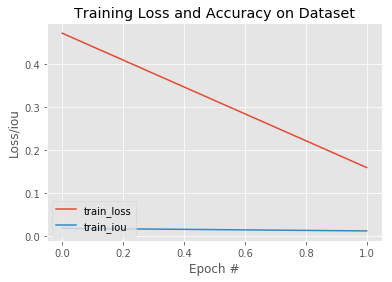

In [0]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize=(12,9))
plt.plot(H.history["iou_thresholded"], label="train_iou_threshold")
plt.plot(H.history["val_iou_thresholded"], label="val_iou_threshold")

subtitle = "BS={}-patch_size={}-num_layers={}".format(BS, str(patch_size), num_layers)
plt.title("Train and Val iuo_thresholded  \newlinw \tiny{}".format(subtitle))
plt.subtitle
plt.xlabel("Epoch #")
plt.ylabel("iou_thresholded")
plt.legend(loc="lower left")
file_plot_train_info = join(path_model, 'info_train_{}.png'.format(utl.datetime_now()))
plt.savefig(file_plot_train_info)


## evaluation

### def

In [0]:
filepath_model = ''


In [0]:
model = load_model(filepath_model, custom_objects={"iou": iou, "iou_thresholded":iou_thresholded})

In [0]:
# predictions
area = 'Sou'
shape_x = 
shape_y = 

org_img_size = ...


s_x = size_sub_sample[0]
s_y = size_sub_sample[1]
stride_x = s_x
stride_y = s_

with h5py.File(file_val_predict_X, 'w') as f2_X:
    dset2 = f2_X.create_dataset('predict_{}'.format(area), 
                                (shape_x, shape_y),
                                dtype=dtype,
                                maxshape=maxshape,
                                chunks=True)
    
    with h5py.File(file_val_split_hfd5_X, 'r') as f1_X:
        dataset_X  = f1_X['all_val_data_X']
        #TODO: use metadata to split '_', 'x', 'y', 'xy'
        metadata = f1_X.metadata
        
        for dim_str in ['_', 'x', 'y', 'xy']:
            org_img_size = ...
            dataset_dim =...
        
            i_max = (org_img_size[0] // stride) + 1 - (size // stride)
            j_max = (org_img_size[1] // stride) + 1 - (size // stride)

            k = 0
            for i in range(i_max):
                for j in range(j_max):
                    dset2[i*stride_x : i*stride_x+s_x, j*stride_y : j*stride_y+s_y] = model.predict(dataset_dim[k, :, :, :])
                    k += 1       
 

In [0]:
#TODO: zero unpadding

In [0]:
with h5py.File(file_val_split_hfd5_Y, 'r') as f1_Y:
    dataset_Y  = f1_Y['all_val_data_Y']

In [0]:
)